In [1]:
import sys
sys.path.append('..')

In [2]:
import os
import pickle
from collections import OrderedDict

import numpy as np
import pandas as pd
import scipy as sp

# import tensorflow as tf
# from tensorflow.keras import Model, Input, losses, layers, optimizers

from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from matplotlib import pyplot as plt
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
import seaborn as sns

import itertools

from src.datasets import adults
from src.evaluation import data_benchmark
# from src.models import vae_keras
# from src.datasets import adults#, dataset_utils

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Load the original data

In [3]:
# Load original data for comparisons
all_data, enc_dict, dec_dict, Scaler, cont_cols, cat_cols = adults.load_adults_data()

# rename it
data_orig = all_data.copy()

# print(all_data)

data_orig_cont = Scaler.inverse_transform(data_orig[cont_cols])
data_orig_df_cont = pd.DataFrame(data_orig_cont, columns = cont_cols)
data_orig_df_cat = data_orig[cat_cols]
data_orig_df = pd.concat([data_orig_df_cont, data_orig_df_cat], axis=1)

# print(data_orig_df)
# align columns with original dataset
data_orig_df, all_data  = data_orig_df.align(all_data, join="right", axis=1)

print(data_orig_df)

using original adult dataset
        age  workclass    fnlwgt  education  education-num  marital-status  \
0      39.0          7   77516.0          9           13.0               4   
1      50.0          6   83311.0          9           13.0               2   
2      38.0          4  215646.0         11            9.0               0   
3      53.0          4  234721.0          1            7.0               2   
4      28.0          4  338409.0          9           13.0               2   
...     ...        ...       ...        ...            ...             ...   
32556  27.0          4  257302.0          7           12.0               2   
32557  40.0          4  154374.0         11            9.0               2   
32558  58.0          4  151910.0         11            9.0               6   
32559  22.0          4  201490.0         11            9.0               4   
32560  52.0          5  287927.0         11            9.0               2   

       occupation  relationship  r

# Load the synthetic data (vanilla) and run the evaluation on the vanilla synthetic data

In [4]:
x_cat = np.load('../exp/adult/vanilla/5/X_cat_train.npy', allow_pickle=True)
x_num = np.load('../exp/adult/vanilla/5/X_num_train.npy', allow_pickle=True)
y = np.load('../exp/adult/vanilla/5/y_train.npy', allow_pickle=True)
y = y.reshape(-1,1)

x_train = np.concatenate([x_cat, y], axis=1)
data_synth = np.concatenate([x_train, x_num], axis=1)
data_synth = pd.DataFrame(data_synth, columns=cat_cols+cont_cols)

# preprocess data produced from DM to match the original dataset, for evaluation

# income needs to be transformed to strings to match original raw adult set
map_dict = {1: '>50K', 0: '<=50K'}
data_synth['income'] = data_synth['income'].map(map_dict)

# apply same preprocessing as is applied to original raw adult set
data_synth, enc_dict_synth, dec_dict_synth, Scaler_synth, cont_cols, cat_cols = adults.load_adults_data(raw_input_data=data_synth)

# align columns with original dataset
data_orig, data_synth = data_orig.align(data_synth, join="left", axis=1)


data_synth_cont = Scaler.inverse_transform(data_synth[cont_cols])
data_synth_df_cont = pd.DataFrame(data_synth_cont, columns = cont_cols)
data_synth_df_cat = data_synth[cat_cols]
data_synth_df = pd.concat([data_synth_df_cont, data_synth_df_cat], axis=1)

# align columns with original dataset
data_synth_df, all_data  = data_synth_df.align(all_data, join="right", axis=1)

print(data_synth_df)

# # evaluate
# data_benchmark.evaluate_synthetic_data(data_orig, data_synth, cont_cols, cat_cols, [1,1,1,1])

using given synthetic adult dataset
        age  workclass         fnlwgt  education  education-num  \
0      19.0          8  116982.536787         15           10.0   
1      45.0          3   37500.032957         12           14.0   
2      25.0          3  421885.325366         15           10.0   
3      53.0          3  103874.780912         15           10.0   
4      27.0          3  271013.573091         11            9.0   
...     ...        ...            ...        ...            ...   
52091  37.0          6  165422.295809          9           13.0   
52092  26.0          3   20533.436441          5            4.0   
52093  45.0          4  121346.451190          8           11.0   
52094  33.0          3  216914.590585          1            7.0   
52095  43.0          3  180550.106912         11            9.0   

       marital-status  occupation  relationship  race  sex  capital-gain  \
0                   4          14             3     4    1           0.0   
1      

# Load the synthetic dataset (DP) and run the evaluation on the dp synthetic data

In [5]:
x_cat = np.load('../exp/adult/dp/5-e500s0.2/X_cat_train.npy', allow_pickle=True)
x_num = np.load('../exp/adult/dp/5-e500s0.2/X_num_train.npy', allow_pickle=True)
y = np.load('../exp/adult/dp/5-e500s0.2/y_train.npy', allow_pickle=True)
y = y.reshape(-1,1)

x_train = np.concatenate([x_cat, y], axis=1)
data_synth_dp = np.concatenate([x_train, x_num], axis=1)
data_synth_dp = pd.DataFrame(data_synth_dp, columns=cat_cols+cont_cols)

# preprocess data produced from DM to match the original dataset, for evaluation

# income needs to be transformed to strings to match original raw adult set
map_dict = {1: '>50K', 0: '<=50K'}
data_synth_dp['income'] = data_synth_dp['income'].map(map_dict)

# apply same preprocessing as is applied to original raw adult set
data_synth_dp, enc_dict_synth, dec_dict_synth, Scaler_synth, cont_cols, cat_cols = adults.load_adults_data(raw_input_data=data_synth_dp)    

# align columns with original dataset
data_orig, data_synth_dp = data_orig.align(data_synth_dp, join="left", axis=1)


data_synth_dp_cont = Scaler.inverse_transform(data_synth_dp[cont_cols])
data_synth_dp_df_cont = pd.DataFrame(data_synth_dp_cont, columns = cont_cols)
data_synth_dp_df_cat = data_synth_dp[cat_cols]
data_synth_dp_df = pd.concat([data_synth_dp_df_cont, data_synth_dp_df_cat], axis=1)


# align columns with original dataset
data_synth_dp_df, all_data = data_synth_dp_df.align(all_data, join="right", axis=1)

print(data_synth_dp_df)

# # evaluate
# data_benchmark.evaluate_synthetic_data(data_orig, data_synth_dp, cont_cols, cat_cols, [1,1,1,1])

using given synthetic adult dataset
        age  workclass     fnlwgt  education  education-num  marital-status  \
0      90.0          3    12285.0         11            1.0               4   
1      17.0          3    12285.0         11            1.0               2   
2      17.0          7    12285.0         15            1.0               4   
3      90.0          4    12285.0          9           16.0               2   
4      17.0          3  1484705.0         15            1.0               4   
...     ...        ...        ...        ...            ...             ...   
52091  17.0          3  1484705.0         11            1.0               4   
52092  90.0          3  1484705.0         15            1.0               4   
52093  90.0          3  1484705.0         11           16.0               2   
52094  90.0          3    12285.0         11            1.0               5   
52095  17.0          3    12285.0         11            1.0               2   

       occupati

In [6]:
def binning_borders(series, nbin, drop_duplicates=True):
    """Returns a list of bin borders
    e.g. generates a list of 10 values for 9 bins (for [0,1])
    """
    
    bin_borders = [0]
    
    vals = np.sort(series.to_numpy())
    if drop_duplicates==True:
        vals = list(dict.fromkeys(vals)) # drop duplicates

    bin_depth = len(vals)/nbin
    for i in range(1, nbin):
        border_value = vals[int(i*bin_depth)]
        bin_borders.append(border_value)
    bin_borders.append(1.0)
    
    return bin_borders

def value_to_bin_index(x, bin_borders):
    """Returns the index of the bin a value belongs to
    e.g. a list with 10 binning borders consists of 9 bins/indices
    """
    for i in range(len(bin_borders)-1):
        if (x>=bin_borders[i] and x<bin_borders[i+1]):
            return i+1
    if x == 1.0:
        return 19
    if x < 0:
        return 0
    if x > 1.0:
        return 20
    raise Exception("value cannot belong to any bin", x, i, bin_borders, len(bin_borders))

In [86]:
def marginal_distributions(data_orig, data_synth, data_synth_dp, cont_cols, cat_cols, nbin=9, drop_duplicates=True):
    """ 
    Generates equal-depth bins based on the original data.
    Calculates the TVD between two one-dimensional distributions.
    Returns the 1 minus the average TVD over all marginals.
    """
    
    MODEL_NAMES = ["Original data",
                   "Vanilla DM",
                   "DP DM"]
    
    tvds = []
    

    for col in cont_cols:
        
        # discretize/bin based on original data
        bin_borders = binning_borders(data_orig[col], nbin, drop_duplicates)

        vals_orig = data_orig[col].to_numpy()
        vals_synth = data_synth[col].to_numpy()
        vals_synth_dp = data_synth_dp[col].to_numpy()
        bin_counts_orig = []
        bin_counts_synth = []
        bin_counts_synth_dp = []
        for i in range(nbin):
            
            col_bin_orig = [x for x in vals_orig if (x >= bin_borders[i] and x < bin_borders[i+1])]
            if i == (nbin-1):
                col_bin_orig = [x for x in vals_orig if (x >= bin_borders[i] and x <= bin_borders[i+1])]
            
            col_bin_synth = [x for x in vals_synth if (x >= bin_borders[i] and x < bin_borders[i+1])]
            if i == (nbin-1):
                col_bin_synth = [x for x in vals_synth if (x >= bin_borders[i] and x <= bin_borders[i+1])]      
                
            col_bin_synth_dp = [x for x in vals_synth_dp if (x >= bin_borders[i] and x < bin_borders[i+1])]
            if i == (nbin-1):
                col_bin_synth_dp = [x for x in vals_synth_dp if (x >= bin_borders[i] and x <= bin_borders[i+1])]   
            
            bin_counts_orig.append(len(col_bin_orig))
            bin_counts_synth.append(len(col_bin_synth))
            bin_counts_synth_dp.append(len(col_bin_synth_dp))
            
        # add additional bins to each end of the range for synth data outside of range
        bin_counts_orig = [0] + bin_counts_orig + [0]
        bin_counts_synth = [len([x for x in vals_synth if x < bin_borders[0]])] + bin_counts_synth + [len([x for x in vals_synth if x > bin_borders[nbin]])]
        bin_counts_synth_dp =  [len([x for x in vals_synth_dp if x < bin_borders[0]])] + bin_counts_synth_dp + [len([x for x in vals_synth_dp if x > bin_borders[nbin]])]
        
#         print(bin_counts_orig)
#         print(bin_counts_synth)
#         print(bin_counts_synth_dp)
        
        species = []
        for n in range(len(bin_borders)-2):
            species.append((bin_borders[n]+bin_borders[n+1])/2)
        species.append(bin_borders[len(bin_borders)-1])
        
        print(species)
        x = np.arange(len(species)) # label locations
        width = 1/9  # the width of the bars
        multiplier = 0
        
        fig, ax = plt.subplots(layout='constrained')
        measurements = [bin_counts_orig, bin_counts_synth, bin_counts_synth_dp]
#         lim = max(np.max(bin_counts_orig), np.max(bin_counts_synth), np.max(bin_counts_synth_dp))/10
        
        
        
        for a in range(3):
            attribute = MODEL_NAMES[a]
            offset = width*multiplier
#             rects = ax.bar(x + offset, tuple([s / lim for s in measurements[a]]), width, label=attribute)
            rects = ax.bar(x + offset, tuple( measurements[a]), width, label=attribute)
            ax.bar_label(rects, padding=3)
            multiplier += 1
            
        # Add some text for labels, title and custom x-axis tick labels, etc.
        ax.set_ylabel('margins')
        ax.set_title(col)
        ax.set_xticks(x + width, species)
        ax.legend(loc='upper left', ncols=3)
        lim = max(np.max(bin_counts_orig), np.max(bin_counts_synth), np.max(bin_counts_synth_dp))
        ax.set_ylim(0, lim)
        

        

    for col in cat_cols:

        counts_orig_lst = []
        counts_synth_lst = []
        counts_synth_dp_lst = []
        
        counts_orig = data_orig[col].value_counts(normalize=True)
        counts_synth = data_synth[col].value_counts(normalize=True)
        counts_synth_dp = data_synth_dp[col].value_counts(normalize=True)
        
        # align counts and treat non-occuring cat values in synth data
        for index, value in counts_orig.items():
            counts_orig_lst.append(value)
            
            if index in counts_synth:
                counts_synth_lst.append(counts_synth[index])
            else:
                counts_synth_lst.append(0)
                
            if index in counts_synth_dp:
                counts_synth_dp_lst.append(counts_synth_dp[index])
            else:
                counts_synth_dp_lst.append(0)
                
#         print(counts_orig_lst)
#         print(counts_synth_lst)
#         print(counts_synth_dp_lst)
        
        
#     fig, axs = plt.subplots(12, 1, figsize=(20, 120))

#     for fig_index, col in enumerate(list_dfs[0].columns):
#         for df_index, df in enumerate(list_dfs):
#             series_col = df[col].value_counts(normalize=True)

#             min_x = min(series_col.index)
#             max_x = max(series_col.index)

#             x = np.arange(min_x, max_x+1, 1)
#             y = np.zeros(max_x-min_x+1)

#             width = 0.20  # the width of the bars

#             for index, value in series_col.items():
#                 y[index - min_x] = value

#             if max_x <= 5:
#                 xpos = x - width * (len(list_dfs)//2) + df_index*width
#                 axs[fig_index].bar(xpos, y, width, label=names[df_index])
#                 axs[fig_index].xaxis.set_major_locator(MaxNLocator(integer=True))
#             else:
#                 axs[fig_index].plot(x, y, label=names[df_index])


#         axs[fig_index].set_title(col)
#         axs[fig_index].legend()
        
#     print('\n1-TVD (Ind)')
#     print(1-np.average(tvds))
#     return 1-np.average(tvds)

[12.5, 29.0, 37.0, 45.00000000000001, 53.00000000000001, 61.0, 69.0, 77.0, 1.0]


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (9,) and arg 1 with shape (11,).

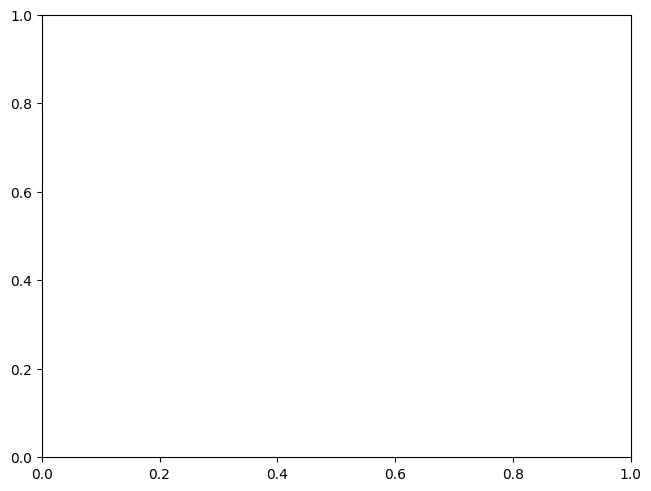

In [87]:
marginal_distributions(data_orig_df, data_synth_df, data_synth_dp_df, cont_cols, cat_cols)